# Providing a Chart Background

## Introduction

As described in previous blog posts, I have been charting water quality data, and wanted to provide
context in terms of the monthly rainfall extrapolated to have occured at each measurement site.  This post describes some  Matplotlib techniques to achieve the affect I wanted.



## Environment
 
This contains the imports and supporting libraries I used.

In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# used for environment documentation
import sys
import os
import platform
import datetime

In [3]:
%load_ext watermark

In [4]:
%load_ext lab_black

## Illustrative dataset

This is a purely toy dataset to illustrate the techniques used.  Starting in January 2015, we generate 80 months worth of random data, and create a pandas dataframe.

In [5]:
date_range = pd.date_range(
    start='1/1/2015', periods=80, freq='M'
)

data_d = {
    'site_code': 'STU100',
    'datesampletaken': date_range,
    'turbidity_ntu': np.random.normal(
        loc=20, scale=5, size=len(date_range)
    ),
}
df_clean = pd.DataFrame(data_d)

### Initial chart

The initial chart uses Seaborn to generate a long strip chart style graphic

In [32]:
def chart_turbidity():
    #  generate a long narrow strip chart
    fig, ax = plt.subplots(figsize=(8, 2))

    # the physical value we are plotting
    val = 'turbidity_ntu'

    sns.lineplot(
        x='datesampletaken',
        y=val,
        data=df_clean,
        ax=ax,
        marker='s',
        markersize=3,
        markerfacecolor='black',
    )

    # set x,y grid
    ax.grid(axis='both')

    # set axis labels
    ax.set_xlabel('Date')

    ylabel = 'Turbidity (NTU)'
    ax.set_ylabel(ylabel)

    # add an overall figure title
    fig.suptitle(
        'Site Code: ' + df_clean.loc[0, 'site_code'],
        fontsize=15,
        ha='center',
        va='top',
    )
    return fig, ax


# end chart_turbidity

(<Figure size 800x200 with 1 Axes>,
 <AxesSubplot:xlabel='Date', ylabel='Turbidity (NTU)'>)

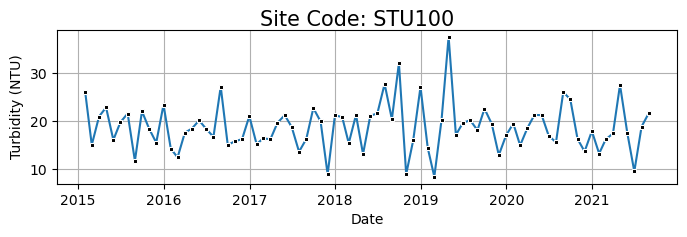

In [33]:
chart_turbidity()

### Climate Data
Now assume we have access monthly rainfall data  (here represented by a random dataset forced to be non-negative).

In [17]:
rain = np.random.normal(
    loc=10, scale=30, size=len(date_range)
)

rain[rain < 0] = 0

rain_d = {
    'site_code': 'STU100',
    'datesampletaken': date_range,
    'rain': rain,
}
df_rain = pd.DataFrame(rain_d)

Quick and dirty plot to show dataset.

<AxesSubplot:xlabel='datesampletaken'>

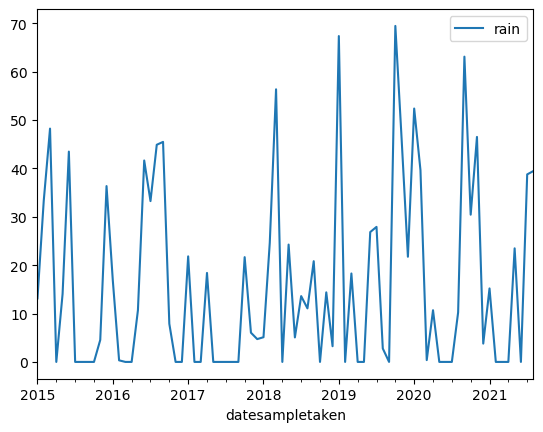

In [18]:
df_rain.plot('datesampletaken', 'rain')

The Monthly Rainfall should be spread across the whole month, not shown as occuring at day 1 of each month.

We define two helper functions:

- one that, given a time stamp, returns a timestamp for the first of the month

- the second, that returns a timestamp for the first of the next month

In [19]:
def month_start(t: pd.Timestamp) -> pd.Timestamp:
    return pd.Timestamp(
        year=t.year,
        month=t.month,
        day=1,
    )


# end month_start


def next_month_start(t: pd.Timestamp) -> pd.Timestamp:
    return pd.Timestamp(
        year=t.year,
        month=t.month,
        day=1,
    ) + pd.DateOffset(months=1)


# end next_month_start

Now we  expand our list of timestamps into a list twice as long, in which for each original timestamp, we have the start of month and start of next month timestamps.

In [22]:
# for each timestamp, create a tuple, and then iterate over that tuple

month_start_end_dates = [
    t
    for r in df_rain['datesampletaken']
    for t in (month_start(r), next_month_start(r))
]

We have to create a new list of rainfall data, with each value duplicated. As above, for each original value, we create a tuple, and iterate over that.

In [25]:
rain2 = [
    r
    for pair in zip(df_rain['rain'], df_rain['rain'])
    for r in pair
]

Plot the result.

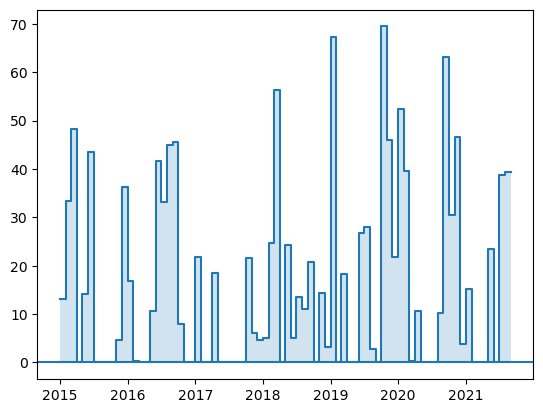

In [26]:
#  plot the monthly rainfall as a line
_ = plt.plot(month_start_end_dates, rain2)

# fill in down to y=0 line

_ = plt.fill_between(
    x=month_start_end_dates,
    y1=rain2,
    alpha=0.2,
)

# plot the y=0 line
_ = plt.axhline(0)

## Combining the two charts

Now we define a function that, given a Matplotlib Axes object, and an x and y array (here called rain_x, and rain_y),  adds a chart as background.

We create a new Axes object that is a twin of the first.  This uses the right hand vertical spine as a new y axis.
We use a standard style of light blue for all marks associated with rainfall data (labels, fill, and tick marks).

Now the default is for the second (twinned) Axes object to overlay the first, which is **reverse** of what we want.
We set the zorder of the first Axes object to be one more that the zorder of our new Axes object, so the Turbidity line overwrite the rainfall (pseudo) barchart, and set  the normally full solid white of the first Axes object to be transparent (non-visible) so the `ax2` ink shows through, underneath the `ax` ink. 



In [51]:
def set_background_chart(ax, rain_x, rain_y) -> None:

    # define light unobtrusive colors (blue for water)
    rain_color = 'lightblue'
    rain_fill = 0.5

    # clone the ax object, and set the right hand y axis label
    # also in a light color
    ax2 = ax.twinx()
    ax2.set_ylabel(
        'Monthly rain (mm)',
        color=rain_color,
    )

    # plot the rainfall data
    ax2.plot(
        rain_x,
        rain_y,
        color=rain_color,
        alpha=rain_fill,
        zorder=1,
    )

    # fill in down to y=0 line
    _ = ax2.fill_between(
        x=rain_x,
        y1=rain_y,
        alpha=rain_fill,
        color=rain_color,
        zorder=1,
        label='Monthly rain',
    )

    # plot the y=0 line
    _ = ax2.axhline(
        0,
        color=rain_color,
    )

    # set rain y labels to be blue
    ax2.tick_params(axis='y', labelcolor=rain_color)

    # make y axis data label small
    ax2.yaxis.set_tick_params(labelsize='x-small')

    # set rainfall plots to back of graphic
    ax.set_zorder(ax2.get_zorder() + 1)

    # make first ax object to be transparent (not solid white)
    ax.patch.set_visible(False)

    return ax2


# end set_background_chart

Create the new chart with rainfall with rainfall underlay.  The aim is to have a chart where the primary data is clearly visible, but the context data is there is you look harder.

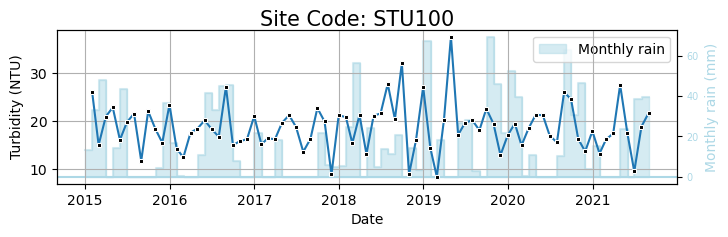

In [46]:
fig, ax = chart_turbidity()
ax2 = set_background_chart(ax, month_start_end_dates, rain2)
ax2.legend(
    loc='upper right',
)

## One last improvement

I decided that putting a monthly grid on the x axis would help clarify the chart.  When you think about it, a monthly grid is a little unusual, with non-uniform gaps between the grid lines.  Matplotlib has helper function to create such a grid (```dates.MonthLocator```).  I set the year grid line dark (`alpha=1`) and the monthly grid lines fainter (`alpha=0.2`).

In [38]:
def set_monthly_grid(ax):

    ax.xaxis.set_minor_locator(
        mpl.dates.MonthLocator(interval=1)
    )
    ax.grid(
        axis='both',
        which='both',
        alpha=0.2,
    )
    ax.grid(
        axis='both',
        which='major',
        alpha=1,
    )


# end set_monthly_grid

## Conclusion

Putting this all together, we get the graphic below.

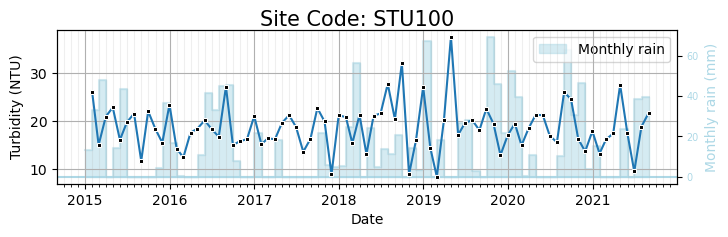

In [48]:
fig, ax = chart_turbidity()
ax2 = set_background_chart(ax, month_start_end_dates, rain2)
set_monthly_grid(ax)
ax2.legend(
    loc='upper right',
)

## Execution Environment

In [49]:
%watermark

Last updated: 2023-08-28T17:00:45.640100+10:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [50]:
%watermark -co -iv

conda environment: base

pandas    : 1.4.4
matplotlib: 3.5.2
numpy     : 1.21.5
sys       : 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
seaborn   : 0.11.2
platform  : 1.0.8

